In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prophet as Prophet
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Import warnings filter
import warnings
warnings.filterwarnings('ignore')



In [2]:
df=pd.read_csv('D:\GIT VS machine learning\TimeSeries_with_EnergyDataset\PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


<h3> EDA

In [3]:
# set Datetime column as indexx and drop the original column
df.index=pd.to_datetime(df['Datetime'])
df.drop(columns='Datetime', inplace=True)
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

Here we can see that the data is collected hourly from 31-12-2002 to 02-01-2018.

In [48]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


<Axes: title={'center': 'Distribution of PJME load in MW'}, ylabel='Freqency'>

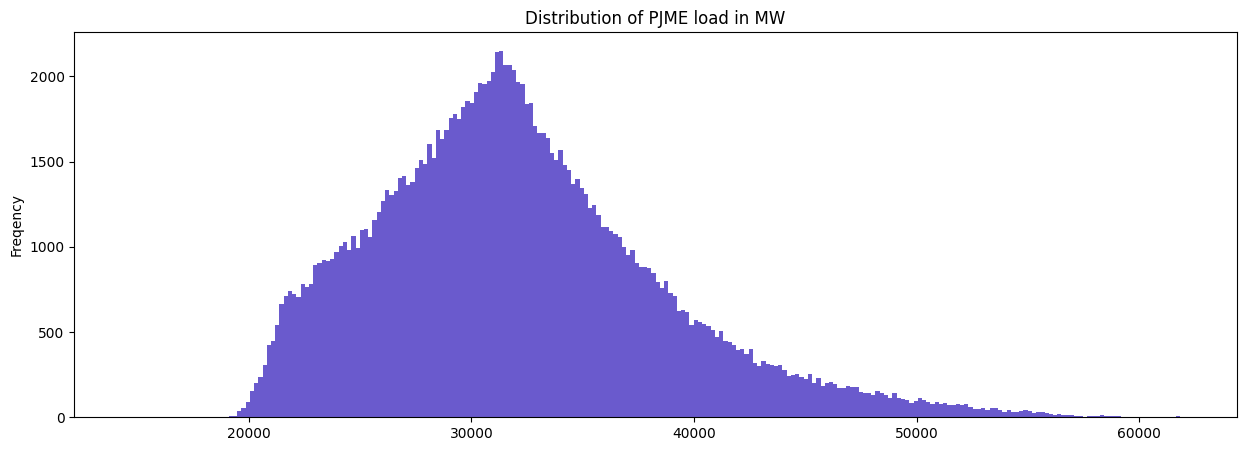

In [55]:
df['PJME_MW'].plot.hist(figsize=(15,5), bins=250, color='slateblue',ylabel='Freqency', title='Distribution of PJME load in MW')

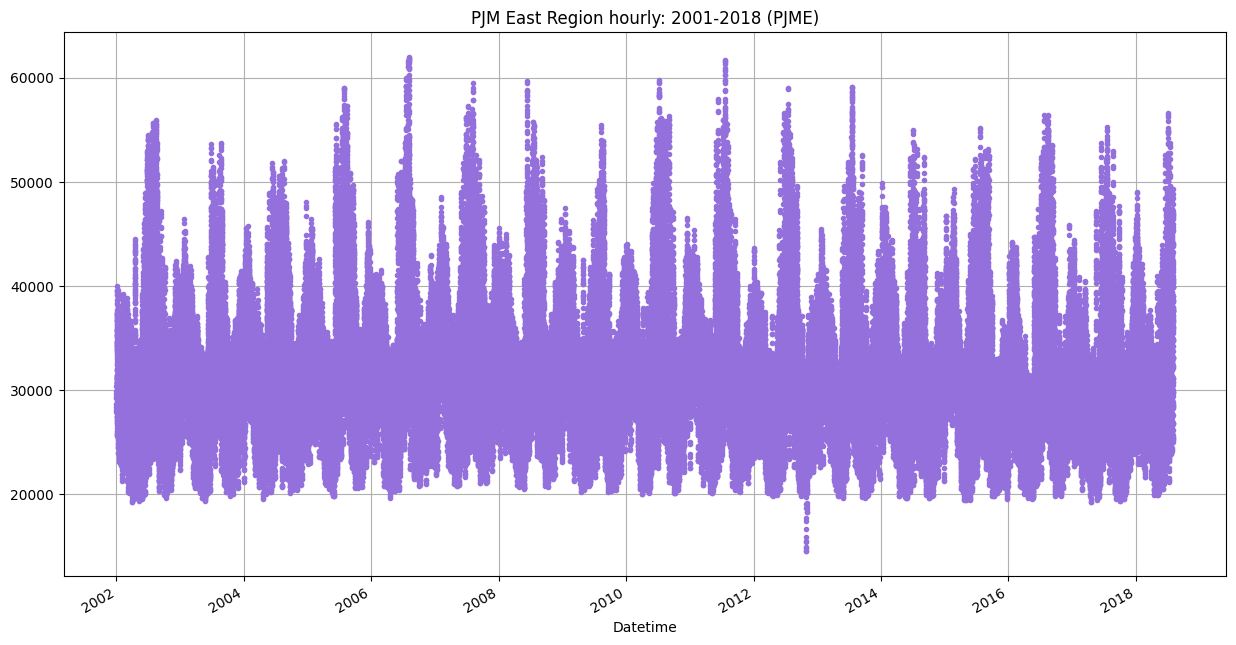

In [57]:

df['PJME_MW'].plot(style='.',grid=True, figsize=(15,8), color='mediumpurple', title='PJM East Region hourly: 2001-2018 (PJME)')
plt.show()

We can see that the consumption peaked above 60000 MW between 2006-2008 and just before 2011. there was also a significant drip just after 2012 going below 20000 MW.

In [4]:
# creating time features form the datetime index column

def time_features(df, label='None'):
    """Will create time series features form the datetime column

    Args:
        df (DataFrame): The dataset we want to create new featres from.
        label (str):  Specifies the column to be used as target variable. Defaults to 'None'. If no label is provided, return only the features (X)
    """

    df.copy()
    df['date'] = df.index

    # Create new columns in the DataFrame by extracting different time-related features from the 'date' column
    df['dayofweek'] = df['date'].dt.dayofweek    # (0=Monday, 6=Sunday)
    df['hour'] = df['date'].dt.hour              # hour of the day (0-23)
    df['quarter'] = df['date'].dt.quarter        # (1-4)
    df['month'] = df['date'].dt.month            # (1-12)
    df['year'] = df['date'].dt.year              # year
    df['dayofyear'] = df['date'].dt.dayofyear    # day of the year (1-365 or 1-366)
    df['dayofmonth'] = df['date'].dt.day         # day of the month (1-31)
    df['weekofyear'] = df['date'].dt.isocalendar().week # ISO week of the year (1-53)

    # Select the newly created time series features into a DataFrame 'x'
    x = df[['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear', 'dayofmonth', 'weekofyear']]

    # Extracting column based on name
    if label:
        y = df[label]
        return x, y  # Return both X and y if label is provided
    
    return x  # Return only X if no label is provided

In [5]:
x,y=time_features(df, label='PJME_MW')
df_ft=pd.concat([x,y], axis=1)
df_ft.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


<Axes: title={'center': 'Plotting data for 2013'}, xlabel='Datetime', ylabel='MW uasage'>

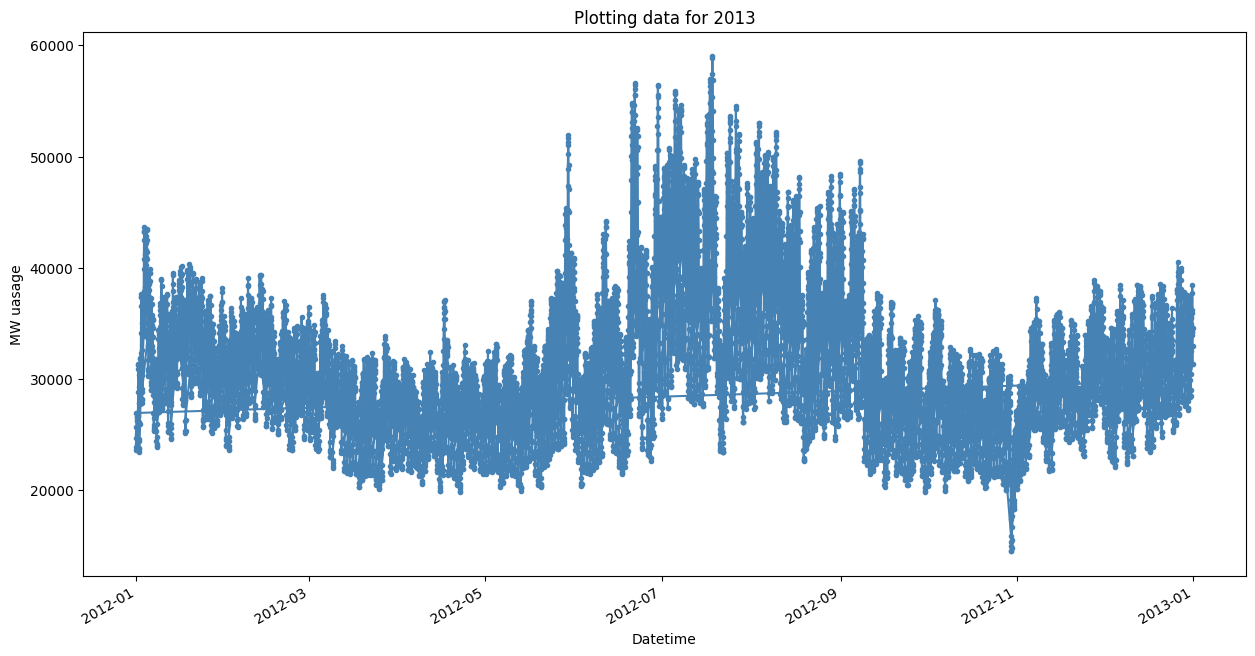

In [8]:
# Plotting to find when the dip in usage took place.

df[df.index.year==2013 & 2012]['PJME_MW'].plot(figsize=(15,8), marker='.', linestyle='-', color='steelblue', ylabel='MW uasage',title='Plotting data for 2013')

We can see around November 2012 there has been a dip in usage below 20000 MW.